#Maxim model
we will be using pre trained maxim model for low light image enhancement.Importing from tensorflow hub.

MAXIM family of models share the same backbone for performing: denoising, dehazing, deblurring, deraining, and enhancement.

In [1]:
task = "Enhancement"  # @param ["Denoising", "Dehazing_Indoor", "Dehazing_Outdoor", "Deblurring", "Deraining", "Enhancement", "Retouching"]

model_handle_map = {
    "Denoising": [
        "https://tfhub.dev/sayakpaul/maxim_s-3_denoising_sidd/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Denoising/input/0003_30.png",
    ],
    "Dehazing_Indoor": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_dehazing_sots-indoor/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Dehazing/input/0003_0.8_0.2.png",
    ],
    "Dehazing_Outdoor": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_dehazing_sots-outdoor/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Dehazing/input/1444_10.png",
    ],
    "Deblurring": [
        "https://tfhub.dev/sayakpaul/maxim_s-3_deblurring_gopro/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Deblurring/input/1fromGOPR0950.png",
    ],
    "Deraining": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_deraining_raindrop/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Deraining/input/15.png",
    ],
    "Enhancement": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_enhancement_lol/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Enhancement/input/a4541-DSC_0040-2.png",
    ],
    "Retouching": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_enhancement_fivek/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Enhancement/input/a4541-DSC_0040-2.png",
    ],
}

model_handle = model_handle_map[task]
ckpt = model_handle[0]
print(f"TF-Hub handle: {ckpt}.")

TF-Hub handle: https://tfhub.dev/sayakpaul/maxim_s-2_enhancement_lol/1.


From above we choose Enhancement task for importing 
the enhancemnt model url as ckpt.

**Importing libraries**

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

Installing library to unzip LOLdatset.zip

In [3]:
!sudo apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


load LOLdataset

In [ ]:
!7z x LOLdataset.zip

#Preprocessing images

In [5]:
def resize_image(image, target_dim):
    # Resize the image so that the shorter dimension becomes `target_dim`.
    shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
    short_dim = min(shape)
    scale = target_dim / short_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    image = tf.image.resize(image, new_shape)

    # Central crop the image.
    image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

    return image


def process_image(image_path, target_dim=256):
    input_img = np.asarray(Image.open(image_path).convert("RGB"), np.float32) / 255.0
    input_img = tf.expand_dims(input_img, axis=0)
    input_img = resize_image(input_img, target_dim)
    return input_img

#Predictions

In [6]:
def get_model(model_url: str, input_resolution: tuple) -> tf.keras.Model:
    inputs = tf.keras.Input((*input_resolution, 3))
    hub_module = hub.KerasLayer(model_url)

    outputs = hub_module(inputs)

    return tf.keras.Model(inputs, outputs)


# Based on https://github.com/google-research/maxim/blob/main/maxim/run_eval.py
def infer(image_path: str, model: tf.keras.Model, input_resolution=(256, 256)):
    preprocessed_image = process_image(image_path, input_resolution[0])

    preds = model.predict(preprocessed_image)
    if isinstance(preds, list):
        preds = preds[-1]
        if isinstance(preds, list):
            preds = preds[-1]

    preds = np.array(preds[0], np.float32)
    final_pred_image = np.array((np.clip(preds, 0.0, 1.0)).astype(np.float32))
    return final_pred_image

#Inference

Image paths

In [21]:
image_paths=['our485/low/10.png','our485/low/100.png','our485/low/112.png','our485/low/120.png',
               'our485/low/12.png']

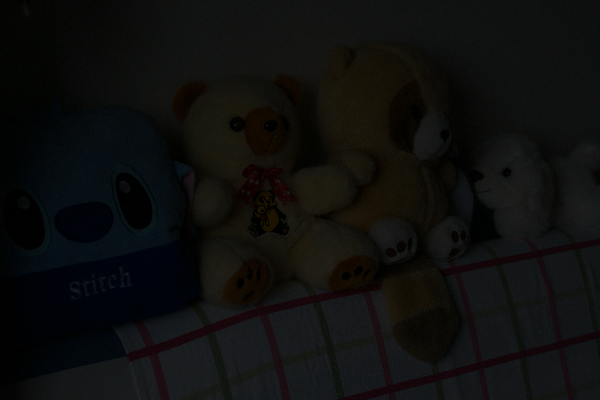

In [23]:
image_path="our485/low/10.png"
Image.open(image_path)

Running prediction

In [22]:
input_resolution = (256, 256)

model = get_model(ckpt, input_resolution)
final_pred_images=[]

for image_path in image_paths:
  final_pred_images.append(infer(image_path, model, input_resolution))


#final_pred_image = infer(image_path, model, input_resolution)

1/1 [==============================] - 10s 10s/step



#Visualization

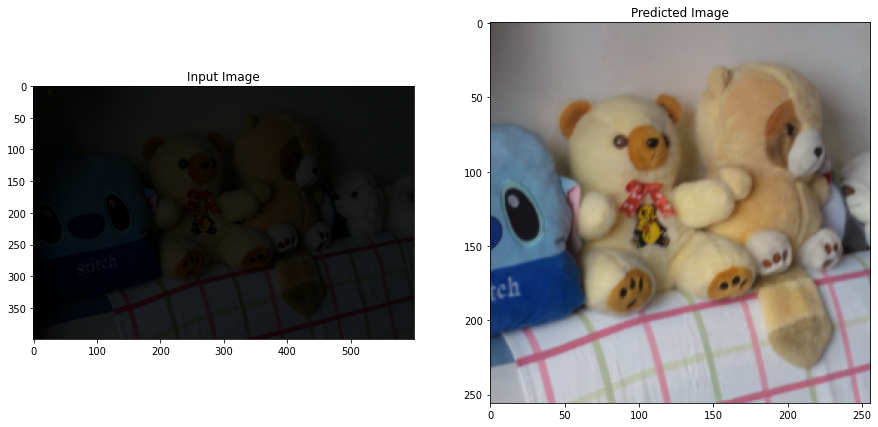

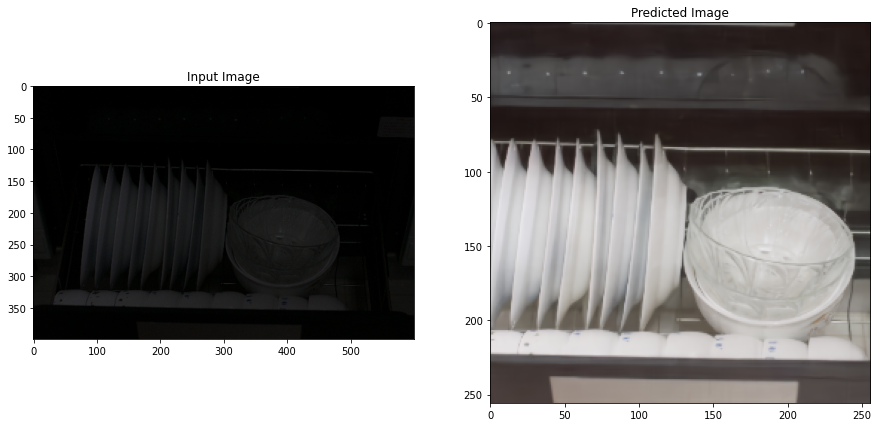

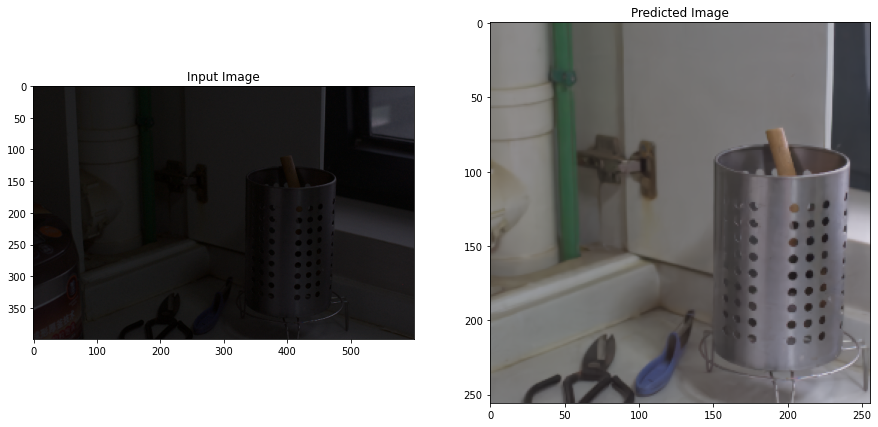

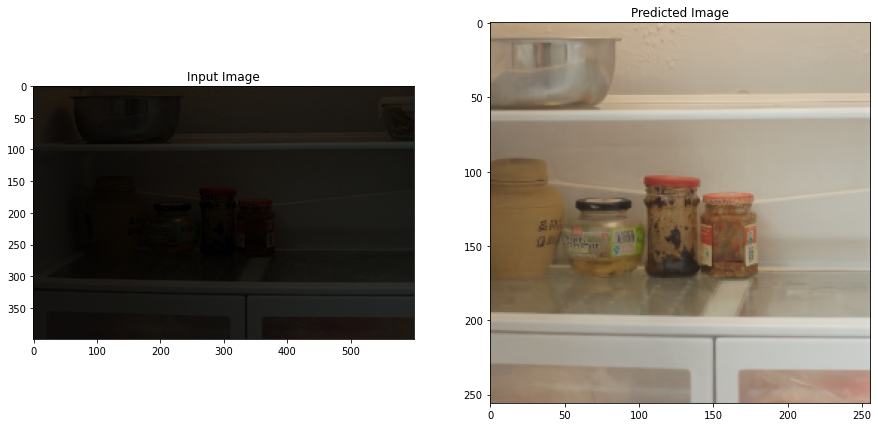

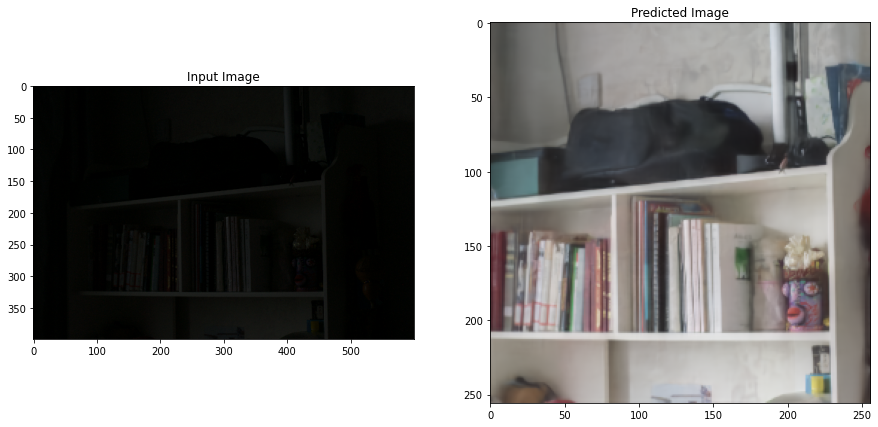

In [24]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)




for (image_path, final_pred_image) in zip(image_paths,final_pred_images):
  plt.figure(figsize=(15, 15))
  plt.subplot(1, 2, 1)
  input_image = np.asarray(Image.open(image_path).convert("RGB"), np.float32) / 255.0
  imshow(input_image, "Input Image")

  plt.subplot(1, 2, 2)
  imshow(final_pred_image, "Predicted Image")

